In [1]:
import numpy as np
import matplotlib.pyplot as plt

Nesse notebook, será construído uma rede neural a mão que consegue simular a porta lógica XOR, utilizando apenas a biblioteca NumPy. Enquanto os exemplos serão ilustrados considerando esse problema, essa mesma rede pode ser utilizado para resolver outros problemas mais complexos, como utilizada na [MNIST a mão](mnist_from_scratch.ipynb).

In [2]:
class Sigmoid:
    def f(self, x):
        return 1 / (1 + np.exp(-x))
    def f_prime(self, x):
        return self.f(x) * (1-self.f(x))

In [3]:
class MSELoss:
    def f(self, y_hat, y):
        return np.sum((y_hat - y)**2)/len(y_hat)
    def f_prime(self, y_hat, y):
        return 2*(y_hat - y)

## Diagrama da rede e derivadas
A rede possuí duas entradas e uma saída correspondentes a tabela-verdade do XOR. Nesse caso ela também possuirá uma hidden layer com dois neurônios.
![Xor diagram](Imagens/xor_diagram_nn.png)

In [4]:
class Layer:
    def __init__(self, n_of_inputs: int, n_of_neurons: int , activation, bias: float=0.0):
        self.n_of_inputs = n_of_inputs
        self.n_of_neurons = n_of_neurons
        self.activation = activation
        self.bias = np.ones((1, n_of_neurons)) * bias # bias, inicializado como 0 por padrão
        self.weights = np.random.uniform(-1, 1, (n_of_inputs, n_of_neurons)) # matriz de pesos 
        
        # As variáveis abaixo são necessárias para o backward
        self.weight_gradient = None  # vetor de gradiente dos pesos
        self.bias_gradient = None # vetor de gradiente do bias
        self.layer_inputs = None # output da camada anterior, ou as entradas da rede caso for a primeira camada
        self.linear_output = None # resultado antes de ser aplicada a função de ativação -> linear_output = a @ w + b

    def forward(self, x):
        """
        Forward propagation da camada
        """
        # Shapes:
        # Primeira para a segunda camada: (1, 2) @ (2, 2) = (1, 2)
        # Segunda para a terceira camada: (1, 2) @ (2, 1) = (1, 1)
        self.layer_inputs = x 
        dot_product = self.layer_inputs @ self.weights 
        self.linear_output = dot_product + self.bias
        output = self.activation.f(self.linear_output)
        return output

    def backward(self, chain_rule_derivatives):
        """
        Cálculo dos gradientes da camada. 
        É calculada as derivadas em relação a matriz de pesos e o bias da camada (dC_dw e dC_db), e a 
        derivada em relação ao linear_output (dC_da), para que possa mandar essa derivada para trás para calcular
        o gradiente dos pesos das camadas anteriores, conforme o diagrama
        Parâmetros:
        chain_rule_derivatives - derivada calculada através da regra da cadeia, que foi mandada da camada seguinte (dC_da1)
        Retorno:
        updated_chain_rule_derivatives - derivada calculada através da regra da cadeia, para ser mandada para a camada anterior (dc_da0)
        """
        da1_dz = self.activation.f_prime(self.linear_output) 
        dz_dw = self.layer_inputs
        dz_da0 = self.weights
        
        dC_dw = dz_dw.T @ (da1_dz * chain_rule_derivatives) 
        dC_db = 1 * da1_dz * chain_rule_derivatives
        dC_da0 = (chain_rule_derivatives * da1_dz) @ dz_da0.T
        
        updated_chain_rule_derivatives = dC_da0
        self.weight_gradient = dC_dw
        self.bias_gradient = dC_db
        
        return updated_chain_rule_derivatives

## Classe Rede Neural
Essa classe é a que será utilizada para construir o modelo. Utilizando a função *append layers* é possível adicionar quantas camadas que quiser à rede.

In [5]:
class NeuralNetwork:
    def __init__(self, input_size, lr):
        self.layers = []
        self.input_size = input_size
        self.lr = lr

    def forward(self, x):
        """
        Forward propagation da rede
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, loss_derivative):
        """
        Backward propagation da rede.
        Calcula os gradientes e aplica o algoritmo de gradiente descendente para atualizar os pesos e os bias
        """
        # Cálculo dos gradientes
        chain_rule_derivatives = loss_derivative
        for layer in reversed(self.layers):
            chain_rule_derivatives = layer.backward(chain_rule_derivatives)
        
        # Gradiente descendente
        for layer in self.layers:
            layer.weights -= layer.weight_gradient * self.lr
            layer.bias -= layer.bias_gradient * self.lr

    # Faz o forward chamando o objeto, passando os inputs como parâmetro, da mesma forma que o PyTorch faz
    def __call__(self, inputs):
        return self.forward(inputs)

    def append_layer(self, output_number: int, activation, bias: float=0.0):
        """
        Dado um número de saída, adiciona uma camada ao fim da rede neural
        Ex: nn = NeuralNetwork(...)
          nn.append_layer(...)
          nn.append_layer(...)
          ...
        """
        # Caso seja a primeira camada
        if len(self.layers) == 0:
            new_layer_input = self.input_size
        else:
            new_layer_input = self.layers[-1].n_of_neurons

        self.layers.append(Layer(new_layer_input, output_number, activation, bias))

## Tabela-verdade do XOR

In [6]:
# Uma dimensão extra é adicionada a cada combinação para ficar no formato (1, 2),
# a fim de fazer as multiplicações de matrizes no forward
X = np.array([[[0,0]], [[1, 0]], [[1, 1]], [[0, 1]]])
y = np.array([0, 1, 0, 1])

Os pesos são inicializados selecionando aleatoriamente em uma distribuição uniforme entre -1 e 1. Dessa forma, pode ser que seja necessário rodar mais de uma vez para obter uma loss perto de 0, caso aconteça de por chance ter uma inicialização que não favoreça o aprendizado do modelo.

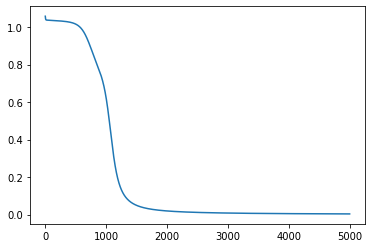

In [7]:
lr = 0.2
criterion = MSELoss()
losses = []
nn = NeuralNetwork(2, lr)
nn.append_layer(2, activation=Sigmoid())
nn.append_layer(1, activation=Sigmoid())
for epoch in range(5000):
    total_loss = 0
    for x, y0 in zip(X, y):
        # Calcula a previsão
        predicted = nn.forward(x)
        # Computa a loss (float) e a derivada da loss (vetor)
        loss = criterion.f(predicted, y0)
        loss_derivative = criterion.f_prime(predicted, y0)
        # Faz o backward da rede
        nn.backward(loss_derivative)
        total_loss += loss
    losses.append(total_loss)

plt.plot(losses)
plt.show()

In [8]:
def predict(inputs: np.array):
    predicted = nn.forward(inputs)
    print(f"Entrada: {inputs[0][0]}, {inputs[0][1]}\nXOR: {round(predicted[0][0])}")

In [9]:
for x in X:
    predict(x)

Entrada: 0, 0
XOR: 0
Entrada: 1, 0
XOR: 1
Entrada: 1, 1
XOR: 0
Entrada: 0, 1
XOR: 1
